# Population as a raster grid

Until now, all the data you were working with were tables. However, not
everything is a table. Raster data are not that common in social
geography, but spatial data science is full of it, from satellite
imagery to population grids. In this session, you will learn how to work
with spatial raster data in Python and how to link raster to vector
using the ecosystem around the `xarray` package.

## Arrays and their many dimensions

Raster data are represented as arrays. Those can take many forms and
shapes. You already know `pandas` data structures, so let’s start with
those.

A `pandas.Series` is a 1-dimensional array with an index. A typical
array contains values of the same data type (e.g. `float` numbers), as
does a typical `Series`.

When it comes to geospatial raster data, one dimension is not enough.
Even the most basic raster, something like a [digital terrain
model](https://en.wikipedia.org/wiki/Digital_elevation_model) (DTM),
requires two dimensions. One represents longitude (or x when projected),
while the other latitude (or y), resulting in a 2-dimensional array.

But you don’t have to stop there. Take a typical satellite image. The
longitude and latitude dimensions are still present, but you have
different bands representing blue, green, red and often near-infra-red
frequencies, resulting in a 3-dimensional array (`lon`, `lat`, `band`).
Throw in time, and you’re now dealing with a 4-dimensional array (`lon`,
`lat`, `band`, `time`).

All these use cases fall under the umbrella of N-dimensional array
handling covered by the `xarray` package. Whereas a `pandas.Series` is a
1-dimensional array with an index, `xarray.DataArray` is an
N-dimensional array with N indexes. Combining multiple `Series` gives
you a `pandas.DataFrame`, where each column can have a different data
type (e.g. one numbers, other names). Combining multiple
`xarray.DataArray`s gives you a `xarray.Dataset`, where each array can
have a different data type. There’s a lot of similarity between `pandas`
and `xarray`, but also some differences.

Let’s read some raster and explore `xarray` objects in practice.

In [1]:
import datashader as ds
import geopandas as gpd
import rioxarray
import xarray as xr
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import xvec

from geocube.api.core import make_geocube

## Population grids

Today, you will be working with the data from the [Global Human
Settlement Layer](https://ghsl.jrc.ec.europa.eu/datasets.php) (GHSL)
developed by the Joint Research Centre of the European Commission.
Unlike in all previous hands-on sessions, the data is not pre-processed
and you could read it directly from the open data repository. However,
since that seems to be a bit unstable lately, use the copy stored as
part of this course.

The first layer you will open is a population grid. GHSL covers the
whole world divided into a set of tiles, each covering an area of 1,000
by 1,000 km at a resolution of 100m per pixel. The link below points to
a single tile[1] covering most of Eastern Europe.

[1] See the distribution of tiles in the [data
repository](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop).

In [2]:
pop_url = (
    "https://martinfleischmann.net/sds/chapter_08/data/"
    "GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0_R4_C20.zip"
      )
pop_url


'https://martinfleischmann.net/sds/chapter_08/data/GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0_R4_C20.zip'

> **Original data**
>
> You can, alternatively, try reading the original data directly using
> this URL:
>
> ``` py
> pop_url = (
>     "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/"
>     "GHS_POP_GLOBE_R2023A/GHS_POP_E2030_GLOBE_R2023A_54009_100/"
>     "V1-0/tiles/GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0_R4_C20.zip"
>       )
> ```

The `pop_url` points to a ZIP file. Within that ZIP file is a
[GeoTIFF](https://en.wikipedia.org/wiki/GeoTIFF) containing the actual
raster. There is often no need to download and unzip the file as there’s
a good chance you can read it directly.

### Reading rasters with `rioxarray`

`xarray`, like `pandas` is an agnostic library. It is designed for
N-dimensional arrays but not necessarily geospatial arrays (although
that is often the case…). It means that by default, it is not able to
read geospatial file formats like GeoTIFF. That is where `rioxarray`
comes in. It comes with the support of the usual geo-specific things
like specific file formats or CRS.

In [3]:
p = f"zip+{pop_url}!GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0_R4_C20.tif"
population = rioxarray.open_rasterio(p, masked=True)
population


<xarray.DataArray (band: 1, y: 10000, x: 10000)>
[100000000 values with dtype=float64]
Coordinates:
 * band (band) int64 1
 * x (x) float64 9.59e+05 9.592e+05 ... 1.959e+06 1.959e+06
 * y (y) float64 6e+06 6e+06 6e+06 6e+06 ... 5e+06 5e+06 5e+06 5e+06
 spatial_ref int64 0
Attributes:
 AREA_OR_POINT: Area
 scale_factor: 1.0
 add_offset: 0.0 xarray.DataArray band : 1 y : 10000 x : 10000 ... [100000000 values with dtype=float64] Coordinates: (4) band (band) int64 1 array([1]) x (x) float64 9.59e+05 9.592e+05 ... 1.959e+06 array([ 959050., 959150., 959250., ..., 1958750., 1958850., 1958950.]) y (y) float64 6e+06 6e+06 6e+06 ... 5e+06 5e+06 array([5999950., 5999850., 5999750., ..., 5000250., 5000150., 5000050.]) spatial_ref () int64 0 crs_wkt : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] spatial_ref : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] GeoTransform : 959000.0 100.0 0.0 6000000.0 0.0 -100.0 array(0) Indexes: (3) band PandasIndex PandasIndex(Index([1], dtype='int64', name='band')) x PandasIndex PandasIndex(Index([ 959050.0, 959150.0, 959250.0, 959350.0, 959450.0, 959550.0,
 959650.0, 959750.0, 959850.0, 959950.0,
 ...
 1958050.0, 1958150.0, 1958250.0, 1958350.0, 1958450.0, 1958550.0,
 1958650.0, 1958750.0, 1958850.0, 1958950.0],
 dtype='float64', name='x', length=10000)) y PandasIndex PandasIndex(Index([5999950.0, 5999850.0, 5999750.0, 5999650.0, 5999550.0, 5999450.0,
 5999350.0, 5999250.0, 5999150.0, 5999050.0,
 ...
 5000950.0, 5000850.0, 5000750.0, 5000650.0, 5000550.0, 5000450.0,
 5000350.0, 5000250.0, 5000150.0, 5000050.0],
 dtype='float64', name='y', length=10000)) Attributes: (3) AREA_OR_POINT : Area scale_factor : 1.0 add_offset : 0.0

Above, you can see the representation of the population grid as a
`DataArray`. It has three dimensions (`"band"`, `"x"`, `"y"`) with a
resolution 1x10,000x10,000 and values as `float`.

`rioxarray` gives you a handy `.rio` accessor on `xarray` objects,
allowing you to access geospatial-specific tools. Like retrieval of CRS.

In [4]:
population.rio.crs

CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

Or the extent of the raster (in the CRS shown above).

In [5]:
population.rio.bounds()

(959000.0, 5000000.0, 1959000.0, 6000000.0)

The missing, masked data can be represented as as specific value,
especially when dealing with integer arrays. You can check which one:

In [6]:
population.rio.nodata

nan

### Plotting with `datashader`

Plotting a raster with a resolution of 10,000x10,000 pixels can be
tricky. Often, the resolution is even larger than that. The best way to
plot is to resample the data to a smaller resolution that better fits
the screen. A handy tool that can do that quickly is
[`datashader`](https://datashader.org). Let’s use it to plot the array
as 600x600 pixels.

In [7]:
canvas = ds.Canvas(plot_width=600, plot_height=600)
agg = canvas.raster(population.where(population>0).sel(band=1))
agg


<xarray.DataArray (y: 600, x: 600)>
array([[4.21513869, 3.52179019, 6.29294423, ..., 1.66938128, 0.82322911,
 nan],
 [1.04041781, 1.57566844, 4.50548627, ..., nan, 0.15449866,
 nan],
 [ nan, 3.18057789, 2.21502486, ..., nan, nan,
 nan],
 ...,
 [ nan, nan, nan, ..., 4.05967611, 1.9045163 ,
 3.70262405],
 [ nan, nan, nan, ..., 7.2545469 , 6.44937184,
 1.5507871 ],
 [ nan, nan, nan, ..., 0.76526973, 1.16737383,
 0.21985548]])
Coordinates:
 * x (x) float64 9.598e+05 9.615e+05 9.632e+05 ... 1.957e+06 1.958e+06
 * y (y) float64 5.999e+06 5.998e+06 5.996e+06 ... 5.002e+06 5.001e+06
Attributes:
 res: 100.0
 x_range: (959000.0, 1959000.0)
 y_range: (5000000.0, 6000000.0) xarray.DataArray y : 600 x : 600 4.215 3.522 6.293 2.667 2.879 2.336 ... 1.52 1.683 0.7653 1.167 0.2199 array([[4.21513869, 3.52179019, 6.29294423, ..., 1.66938128, 0.82322911,
 nan],
 [1.04041781, 1.57566844, 4.50548627, ..., nan, 0.15449866,
 nan],
 [ nan, 3.18057789, 2.21502486, ..., nan, nan,
 nan],
 ...,
 [ nan, nan, nan, ..., 4.05967611, 1.9045163 ,
 3.70262405],
 [ nan, nan, nan, ..., 7.2545469 , 6.44937184,
 1.5507871 ],
 [ nan, nan, nan, ..., 0.76526973, 1.16737383,
 0.21985548]]) Coordinates: (2) x (x) float64 9.598e+05 9.615e+05 ... 1.958e+06 array([ 959833.333333, 961500. , 963166.666667, ..., 1954833.333333,
 1956500. , 1958166.666667]) y (y) float64 5.999e+06 5.998e+06 ... 5.001e+06 array([5999166.666667, 5997500. , 5995833.333333, ..., 5004166.666667,
 5002500. , 5000833.333333]) Indexes: (2) x PandasIndex PandasIndex(Index([ 959833.3333333334, 961500.0, 963166.6666666667,
 964833.3333333334, 966500.0, 968166.6666666667,
 969833.3333333334, 971500.0, 973166.6666666667,
 974833.3333333334,
 ...
 1943166.666666667, 1944833.3333333337, 1946500.0000000002,
 1948166.666666667, 1949833.3333333337, 1951500.0000000002,
 1953166.666666667, 1954833.3333333337, 1956500.0000000002,
 1958166.666666667],
 dtype='float64', name='x', length=600)) y PandasIndex PandasIndex(Index([5999166.666666666, 5997500.0, 5995833.333333333,
 5994166.666666666, 5992500.0, 5990833.333333333,
 5989166.666666666, 5987500.0, 5985833.333333333,
 5984166.666666666,
 ...
 5015833.333333333, 5014166.666666666, 5012500.0,
 5010833.333333333, 5009166.666666666, 5007500.0,
 5005833.333333333, 5004166.666666666, 5002500.0,
 5000833.333333333],
 dtype='float64', name='y', length=600)) Attributes: (3) res : 100.0 x_range : (959000.0, 1959000.0) y_range : (5000000.0, 6000000.0)

You can see that the result is a new `xarray.DataArray` with a
resolution 600x600. The built-in matplotlib-based plotting can easily
handle that.

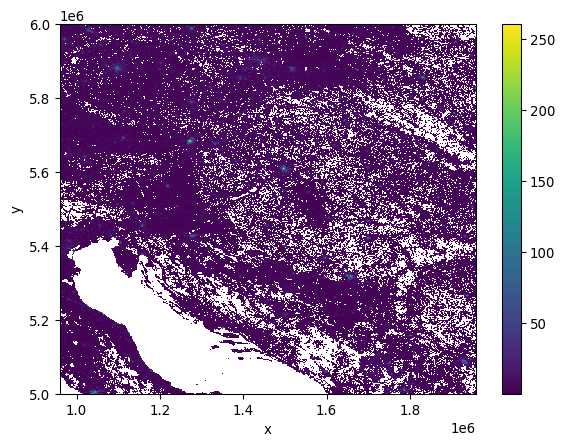

In [8]:
_ = agg.plot()

## Clipping based on geometry

Daling with large rasters is often impractical if you are interested in
a small subset, for example, representing a single city.

### Functional Urban Areas

In this case, you may want to work only with the data covering Budapest,
Hungary, defined by its [functional urban
area](https://ghsl.jrc.ec.europa.eu/ghs_fua.php) (FUA), available as
another data product on GHSL. FUAs are available as a single GeoPackage
with vector geometries.

In [9]:
fua_url = (
    "https://martinfleischmann.net/sds/chapter_08/data/"
    "GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.zip"
)
p = f"zip+{fua_url}!GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg"
fuas = gpd.read_file(p)
budapest = fuas.query("eFUA_name == 'Budapest'")
budapest.explore()


Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<html>
<head>
 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-3.7.1.min.js"></script>
 <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://netdna.bootstrapcdn.com/bootstrap/3.0.0/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@fortawesome/fontawesome-free@6.2.0/css/all.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_787bd98635ea3cf441e05d3103b89dec {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 .leaflet-container { font-size: 1rem; }
 </style>
 
 
 <style>
 .foliumtooltip {
 
 }
 .foliumtooltip table{
 margin: auto;
 }
 .foliumtooltip tr{
 text-align: left;
 }
 .foliumtooltip th{
 padding: 2px; padding-right: 8px;
 }
 </style>
 
</head>
<body>
 
 
 <div class="folium-map" id="map_787bd98635ea3cf441e05d3103b89dec" ></div>
 
</body>
<script>
 
 
 var map_787bd98635ea3cf441e05d3103b89dec = L.map(
 "map_787bd98635ea3cf441e05d3103b89dec",
 {
 center: [47.47044485323768, 19.212935175082336],
 crs: L.CRS.EPSG3857,
 zoom: 10,
 zoomControl: true,
 preferCanvas: false,
 }
 );
 L.control.scale().addTo(map_787bd98635ea3cf441e05d3103b89dec);

 

 
 
 var tile_layer_988b9bb3456d02c067272400cd5a43f8 = L.tileLayer(
 "https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png",
 {"attribution": "Data by \u0026copy; \u003ca target=\"_blank\" href=\"http://openstreetmap.org\"\u003eOpenStreetMap\u003c/a\u003e, under \u003ca target=\"_blank\" href=\"http://www.openstreetmap.org/copyright\"\u003eODbL\u003c/a\u003e.", "detectRetina": false, "maxNativeZoom": 18, "maxZoom": 18, "minZoom": 0, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 );
 
 
 tile_layer_988b9bb3456d02c067272400cd5a43f8.addTo(map_787bd98635ea3cf441e05d3103b89dec);
 
 map_787bd98635ea3cf441e05d3103b89dec.fitBounds(
 [[47.07677314279965, 18.712248503838712], [47.86411656367571, 19.713621846325957]],
 {}
 );
 
 
 function geo_json_3bd8470d4eb4e8acd9c5b9a4e1fa9d44_styler(feature) {
 switch(feature.id) {
 default:
 return {"fillOpacity": 0.5, "weight": 2};
 }
 }
 function geo_json_3bd8470d4eb4e8acd9c5b9a4e1fa9d44_highlighter(feature) {
 switch(feature.id) {
 default:
 return {"fillOpacity": 0.75};
 }
 }
 function geo_json_3bd8470d4eb4e8acd9c5b9a4e1fa9d44_pointToLayer(feature, latlng) {
 var opts = {"bubblingMouseEvents": true, "color": "#3388ff", "dashArray": null, "dashOffset": null, "fill": true, "fillColor": "#3388ff", "fillOpacity": 0.2, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 2, "stroke": true, "weight": 3};
 
 let style = geo_json_3bd8470d4eb4e8acd9c5b9a4e1fa9d44_styler(feature)
 Object.assign(opts, style)
 
 return new L.CircleMarker(latlng, opts)
 }

 function geo_json_3bd8470d4eb4e8acd9c5b9a4e1fa9d44_onEachFeature(feature, layer) {
 laye

> **Original data**
>
> You can, alternatively, try reading the original data directly using
> this URL:
>
> ``` py
> fua_url = (
>     "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/"
>     "GHS_FUA_UCDB2015_GLOBE_R2019A/V1-0/"
>     "GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.zip"
> )
> ```

If you want to clip the `population` raster to the extent of Budapest
FUA, you can use the `clip` method from the `rioxarray` extension of
`xarray`.

In [10]:
population_bud = population.rio.clip(
    budapest.to_crs(population.rio.crs).geometry
)
population_bud


<xarray.DataArray (band: 1, y: 840, x: 830)>
array([[[nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 ...,
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
 * band (band) int64 1
 * x (x) float64 1.465e+06 1.465e+06 ... 1.548e+06 1.548e+06
 * y (y) float64 5.648e+06 5.648e+06 ... 5.564e+06 5.564e+06
 spatial_ref int64 0
Attributes:
 AREA_OR_POINT: Area
 scale_factor: 1.0
 add_offset: 0.0 xarray.DataArray band : 1 y : 840 x : 830 nan nan nan nan nan nan nan nan ... nan nan nan nan nan nan nan nan array([[[nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 ...,
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan]]]) Coordinates: (4) band (band) int64 1 array([1]) x (x) float64 1.465e+06 1.465e+06 ... 1.548e+06 axis : X long_name : x coordinate of projection standard_name : projection_x_coordinate units : metre array([1465050., 1465150., 1465250., ..., 1547750., 1547850., 1547950.]) y (y) float64 5.648e+06 5.648e+06 ... 5.564e+06 axis : Y long_name : y coordinate of projection standard_name : projection_y_coordinate units : metre array([5647950., 5647850., 5647750., ..., 5564250., 5564150., 5564050.]) spatial_ref () int64 0 crs_wkt : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] spatial_ref : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] GeoTransform : 1465000.0 100.0 0.0 5648000.0 0.0 -100.0 array(0) Indexes: (3) band PandasIndex PandasIndex(Index([1], dtype='int64', name='band')) x PandasIndex PandasIndex(Index([1465050.0, 1465150.0, 1465250.0, 1465350.0, 1465450.0, 1465550.0,
 1465650.0, 1465750.0, 1465850.0, 1465950.0,
 ...
 1547050.0, 1547150.0, 1547250.0, 1547350.0, 1547450.0, 1547550.0,
 1547650.0, 1547750.0, 1547850.0, 1547950.0],
 dtype='float64', name='x', length=830)) y PandasIndex PandasIndex(Index([5647950.0, 5647850.0, 5647750.0, 5647650.0, 5647550.0, 5647450.0,
 5647350.0, 5647250.0, 5647150.0, 5647050.0,
 ...
 5564950.0, 5564850.0, 5564750.0, 5564650.0, 5564550.0, 5564450.0,
 5564350.0, 5564250.0, 5564150.0, 5564050.0],
 dtype='float64', name='y', length=840)) Attributes: (3) AREA_OR_POINT : Area scale_factor : 1.0 add_offset : 0.0

The raster is no longer 10,000x10,000 pixels but only 840x830, covering
the extent of Budapest FUA. You can easily check that by plotting the
clipped array.

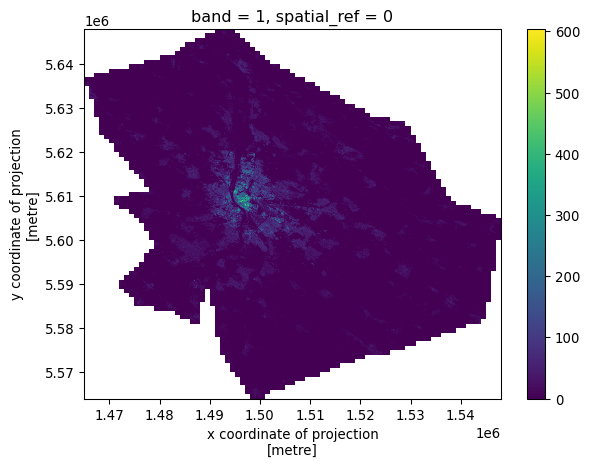

In [11]:
_ = population_bud.plot()

## Array manipulation

While this is technically a 3-dimensional array, the dimension `"band"`
has only one value. Normally, you would get a 2-dimensional array
representing a selected band using the `.sel()` method.

In [12]:
population_bud.sel(band=1)

<xarray.DataArray (y: 840, x: 830)>
array([[nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 ...,
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
 band int64 1
 * x (x) float64 1.465e+06 1.465e+06 ... 1.548e+06 1.548e+06
 * y (y) float64 5.648e+06 5.648e+06 ... 5.564e+06 5.564e+06
 spatial_ref int64 0
Attributes:
 AREA_OR_POINT: Area
 scale_factor: 1.0
 add_offset: 0.0 xarray.DataArray y : 840 x : 830 nan nan nan nan nan nan nan nan ... nan nan nan nan nan nan nan nan array([[nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 ...,
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan]]) Coordinates: (4) band () int64 1 array(1) x (x) float64 1.465e+06 1.465e+06 ... 1.548e+06 axis : X long_name : x coordinate of projection standard_name : projection_x_coordinate units : metre array([1465050., 1465150., 1465250., ..., 1547750., 1547850., 1547950.]) y (y) float64 5.648e+06 5.648e+06 ... 5.564e+06 axis : Y long_name : y coordinate of projection standard_name : projection_y_coordinate units : metre array([5647950., 5647850., 5647750., ..., 5564250., 5564150., 5564050.]) spatial_ref () int64 0 crs_wkt : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] spatial_ref : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] GeoTransform : 1465000.0 100.0 0.0 5648000.0 0.0 -100.0 array(0) Indexes: (2) x PandasIndex PandasIndex(Index([1465050.0, 1465150.0, 1465250.0, 1465350.0, 1465450.0, 1465550.0,
 1465650.0, 1465750.0, 1465850.0, 1465950.0,
 ...
 1547050.0, 1547150.0, 1547250.0, 1547350.0, 1547450.0, 1547550.0,
 1547650.0, 1547750.0, 1547850.0, 1547950.0],
 dtype='float64', name='x', length=830)) y PandasIndex PandasIndex(Index([5647950.0, 5647850.0, 5647750.0, 5647650.0, 5647550.0, 5647450.0,
 5647350.0, 5647250.0, 5647150.0, 5647050.0,
 ...
 5564950.0, 5564850.0, 5564750.0, 5564650.0, 5564550.0, 5564450.0,
 5564350.0, 5564250.0, 5564150.0, 5564050.0],
 dtype='float64', name='y', length=840)) Attributes: (3) AREA_OR_POINT : Area scale_factor : 1.0 add_offset : 0.0

But if you have only one band, you can *squeeze* the array and get rid
of that dimension that is not needed.

In [13]:
population_bud = population_bud.drop_vars("band").squeeze()
population_bud

<xarray.DataArray (y: 840, x: 830)>
array([[nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 ...,
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
 * x (x) float64 1.465e+06 1.465e+06 ... 1.548e+06 1.548e+06
 * y (y) float64 5.648e+06 5.648e+06 ... 5.564e+06 5.564e+06
 spatial_ref int64 0
Attributes:
 AREA_OR_POINT: Area
 scale_factor: 1.0
 add_offset: 0.0 xarray.DataArray y : 840 x : 830 nan nan nan nan nan nan nan nan ... nan nan nan nan nan nan nan nan array([[nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 ...,
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan]]) Coordinates: (3) x (x) float64 1.465e+06 1.465e+06 ... 1.548e+06 axis : X long_name : x coordinate of projection standard_name : projection_x_coordinate units : metre array([1465050., 1465150., 1465250., ..., 1547750., 1547850., 1547950.]) y (y) float64 5.648e+06 5.648e+06 ... 5.564e+06 axis : Y long_name : y coordinate of projection standard_name : projection_y_coordinate units : metre array([5647950., 5647850., 5647750., ..., 5564250., 5564150., 5564050.]) spatial_ref () int64 0 crs_wkt : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] spatial_ref : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] GeoTransform : 1465000.0 100.0 0.0 5648000.0 0.0 -100.0 array(0) Indexes: (2) x PandasIndex PandasIndex(Index([1465050.0, 1465150.0, 1465250.0, 1465350.0, 1465450.0, 1465550.0,
 1465650.0, 1465750.0, 1465850.0, 1465950.0,
 ...
 1547050.0, 1547150.0, 1547250.0, 1547350.0, 1547450.0, 1547550.0,
 1547650.0, 1547750.0, 1547850.0, 1547950.0],
 dtype='float64', name='x', length=830)) y PandasIndex PandasIndex(Index([5647950.0, 5647850.0, 5647750.0, 5647650.0, 5647550.0, 5647450.0,
 5647350.0, 5647250.0, 5647150.0, 5647050.0,
 ...
 5564950.0, 5564850.0, 5564750.0, 5564650.0, 5564550.0, 5564450.0,
 5564350.0, 5564250.0, 5564150.0, 5564050.0],
 dtype='float64', name='y', length=840)) Attributes: (3) AREA_OR_POINT : Area scale_factor : 1.0 add_offset : 0.0

Now a lot what you know from `pandas` works equally in `xarray`. Getting
the minimum:

In [14]:
population_bud.min()

<xarray.DataArray ()>
array(0.)
Coordinates:
 spatial_ref int64 0 xarray.DataArray 0.0 array(0.) Coordinates: (1) spatial_ref () int64 0 crs_wkt : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] spatial_ref : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] GeoTransform : 1465000.0 100.0 0.0 5648000.0 0.0 -100.0 array(0) Indexes: (0) Attributes: (0)

As expected, there are some cells with no inhabitants.

In [15]:
population_bud.max()

<xarray.DataArray ()>
array(603.90405273)
Coordinates:
 spatial_ref int64 0 xarray.DataArray 603.9 array(603.90405273) Coordinates: (1) spatial_ref () int64 0 crs_wkt : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] spatial_ref : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] GeoTransform : 1465000.0 100.0 0.0 5648000.0 0.0 -100.0 array(0) Indexes: (0) Attributes: (0)

The densest cell, on the other hand, has more than 600 people per
hectare.

In [16]:
population_bud.mean()

<xarray.DataArray ()>
array(6.77593517)
Coordinates:
 spatial_ref int64 0 xarray.DataArray 6.776 array(6.77593517) Coordinates: (1) spatial_ref () int64 0 crs_wkt : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] spatial_ref : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] GeoTransform : 1465000.0 100.0 0.0 5648000.0 0.0 -100.0 array(0) Indexes: (0) Attributes: (0)

Mean is, however, only below 7.

In [17]:
population_bud.median()

<xarray.DataArray ()>
array(0.)
Coordinates:
 spatial_ref int64 0 xarray.DataArray 0.0 array(0.) Coordinates: (1) spatial_ref () int64 0 crs_wkt : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] spatial_ref : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] GeoTransform : 1465000.0 100.0 0.0 5648000.0 0.0 -100.0 array(0) Indexes: (0) Attributes: (0)

While the median is 0, there are a lot of cells with 0.

> **DataArray vs scalar**
>
> Notice that `xarray` always returns another `DataArray` even with a
> single value. If you want to get that scalar value, you can use
> `.item()`.
>
> ``` python
> population_bud.mean().item()
> ```
>
>     6.775935172506021

You can plot the distribution of values across the array.

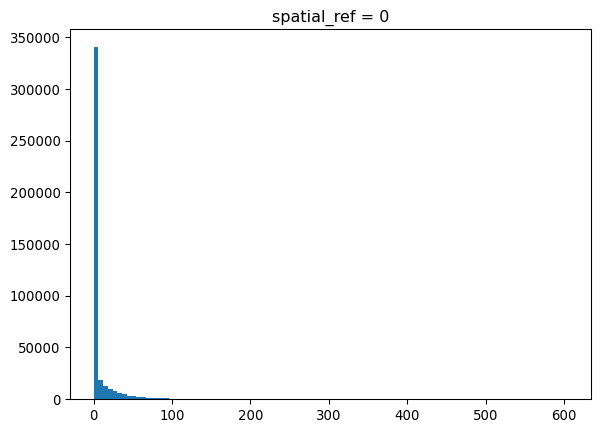

In [19]:
_ = population_bud.plot.hist(bins=100)

Indeed, there are a lot of zeros. Let’s filter them out and check the
distribution again.

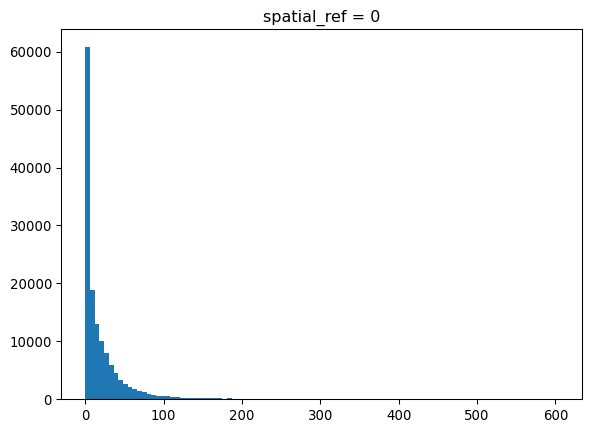

In [20]:
_ = population_bud.where(population_bud>0).plot.hist(bins=100)

As with many observations in urban areas, this follows a power-law-like
distribution with a lot of observations with tiny values and only a few
with large ones.

## Array operations

Let’s assume that you want to normalise population counts by the
built-up volume, which is available as another GHSL product. This time,
on a grid again.

In [21]:
volume_url = (
    "https://martinfleischmann.net/sds/chapter_08/data/"
    "GHS_BUILT_V_E2030_GLOBE_R2023A_54009_100_V1_0_R4_C20.zip"
)
volume_url

'https://martinfleischmann.net/sds/chapter_08/data/GHS_BUILT_V_E2030_GLOBE_R2023A_54009_100_V1_0_R4_C20.zip'

> **Backup data**
>
> You can, alternatively, try reading the original data directly using
> this URL:
>
> ``` py
> volume_url = (
>     "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/"
>     "GHS_BUILT_V_GLOBE_R2023A/GHS_BUILT_V_E2030_GLOBE_R2023A_54009_100/V1-0/tiles/"
>     "GHS_BUILT_V_E2030_GLOBE_R2023A_54009_100_V1_0_R4_C20.zip"
> )
> ```

All work the same as before. You read the GeoTIFF as a `DataArray`.

In [22]:
p = f"zip+{volume_url}!GHS_BUILT_V_E2030_GLOBE_R2023A_54009_100_V1_0_R4_C20.tif"
built_up = rioxarray.open_rasterio(p, masked=True).drop_vars("band").squeeze()
built_up

<xarray.DataArray (y: 10000, x: 10000)>
[100000000 values with dtype=float64]
Coordinates:
 * x (x) float64 9.59e+05 9.592e+05 ... 1.959e+06 1.959e+06
 * y (y) float64 6e+06 6e+06 6e+06 6e+06 ... 5e+06 5e+06 5e+06 5e+06
 spatial_ref int64 0
Attributes:
 AREA_OR_POINT: Area
 scale_factor: 1.0
 add_offset: 0.0 xarray.DataArray y : 10000 x : 10000 ... [100000000 values with dtype=float64] Coordinates: (3) x (x) float64 9.59e+05 9.592e+05 ... 1.959e+06 array([ 959050., 959150., 959250., ..., 1958750., 1958850., 1958950.]) y (y) float64 6e+06 6e+06 6e+06 ... 5e+06 5e+06 array([5999950., 5999850., 5999750., ..., 5000250., 5000150., 5000050.]) spatial_ref () int64 0 crs_wkt : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] spatial_ref : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] GeoTransform : 959000.0 100.0 0.0 6000000.0 0.0 -100.0 array(0) Indexes: (2) x PandasIndex PandasIndex(Index([ 959050.0, 959150.0, 959250.0, 959350.0, 959450.0, 959550.0,
 959650.0, 959750.0, 959850.0, 959950.0,
 ...
 1958050.0, 1958150.0, 1958250.0, 1958350.0, 1958450.0, 1958550.0,
 1958650.0, 1958750.0, 1958850.0, 1958950.0],
 dtype='float64', name='x', length=10000)) y PandasIndex PandasIndex(Index([5999950.0, 5999850.0, 5999750.0, 5999650.0, 5999550.0, 5999450.0,
 5999350.0, 5999250.0, 5999150.0, 5999050.0,
 ...
 5000950.0, 5000850.0, 5000750.0, 5000650.0, 5000550.0, 5000450.0,
 5000350.0, 5000250.0, 5000150.0, 5000050.0],
 dtype='float64', name='y', length=10000)) Attributes: (3) AREA_OR_POINT : Area scale_factor : 1.0 add_offset : 0.0

And clip it to the same extent.

In [23]:
built_up_bud = built_up.rio.clip(budapest.to_crs(built_up.rio.crs).geometry)
built_up_bud

<xarray.DataArray (y: 840, x: 830)>
array([[nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 ...,
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
 * x (x) float64 1.465e+06 1.465e+06 ... 1.548e+06 1.548e+06
 * y (y) float64 5.648e+06 5.648e+06 ... 5.564e+06 5.564e+06
 spatial_ref int64 0
Attributes:
 AREA_OR_POINT: Area
 scale_factor: 1.0
 add_offset: 0.0 xarray.DataArray y : 840 x : 830 nan nan nan nan nan nan nan nan ... nan nan nan nan nan nan nan nan array([[nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 ...,
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan]]) Coordinates: (3) x (x) float64 1.465e+06 1.465e+06 ... 1.548e+06 axis : X long_name : x coordinate of projection standard_name : projection_x_coordinate units : metre array([1465050., 1465150., 1465250., ..., 1547750., 1547850., 1547950.]) y (y) float64 5.648e+06 5.648e+06 ... 5.564e+06 axis : Y long_name : y coordinate of projection standard_name : projection_y_coordinate units : metre array([5647950., 5647850., 5647750., ..., 5564250., 5564150., 5564050.]) spatial_ref () int64 0 crs_wkt : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] spatial_ref : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] GeoTransform : 1465000.0 100.0 0.0 5648000.0 0.0 -100.0 array(0) Indexes: (2) x PandasIndex PandasIndex(Index([1465050.0, 1465150.0, 1465250.0, 1465350.0, 1465450.0, 1465550.0,
 1465650.0, 1465750.0, 1465850.0, 1465950.0,
 ...
 1547050.0, 1547150.0, 1547250.0, 1547350.0, 1547450.0, 1547550.0,
 1547650.0, 1547750.0, 1547850.0, 1547950.0],
 dtype='float64', name='x', length=830)) y PandasIndex PandasIndex(Index([5647950.0, 5647850.0, 5647750.0, 5647650.0, 5647550.0, 5647450.0,
 5647350.0, 5647250.0, 5647150.0, 5647050.0,
 ...
 5564950.0, 5564850.0, 5564750.0, 5564650.0, 5564550.0, 5564450.0,
 5564350.0, 5564250.0, 5564150.0, 5564050.0],
 dtype='float64', name='y', length=840)) Attributes: (3) AREA_OR_POINT : Area scale_factor : 1.0 add_offset : 0.0

You can quickly check what it looks like.

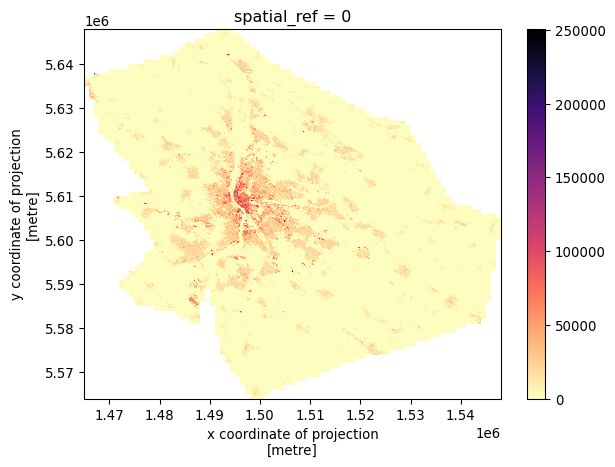

In [24]:
_ = built_up_bud.plot(cmap="magma_r")

The two grids are aligned, meaning that pixels with the same coordinates
represent the same area. This allows us to directly perform array
algebra. Again, you know this from `pandas`.

In [25]:
pop_density = population_bud /  built_up_bud
pop_density


<xarray.DataArray (y: 840, x: 830)>
array([[nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 ...,
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
 * x (x) float64 1.465e+06 1.465e+06 ... 1.548e+06 1.548e+06
 * y (y) float64 5.648e+06 5.648e+06 ... 5.564e+06 5.564e+06
 spatial_ref int64 0 xarray.DataArray y : 840 x : 830 nan nan nan nan nan nan nan nan ... nan nan nan nan nan nan nan nan array([[nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 ...,
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan]]) Coordinates: (3) x (x) float64 1.465e+06 1.465e+06 ... 1.548e+06 axis : X long_name : x coordinate of projection standard_name : projection_x_coordinate units : metre array([1465050., 1465150., 1465250., ..., 1547750., 1547850., 1547950.]) y (y) float64 5.648e+06 5.648e+06 ... 5.564e+06 axis : Y long_name : y coordinate of projection standard_name : projection_y_coordinate units : metre array([5647950., 5647850., 5647750., ..., 5564250., 5564150., 5564050.]) spatial_ref () int64 0 crs_wkt : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] spatial_ref : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] GeoTransform : 1465000.0 100.0 0.0 5648000.0 0.0 -100.0 array(0) Indexes: (2) x PandasIndex PandasIndex(Index([1465050.0, 1465150.0, 1465250.0, 1465350.0, 1465450.0, 1465550.0,
 1465650.0, 1465750.0, 1465850.0, 1465950.0,
 ...
 1547050.0, 1547150.0, 1547250.0, 1547350.0, 1547450.0, 1547550.0,
 1547650.0, 1547750.0, 1547850.0, 1547950.0],
 dtype='float64', name='x', length=830)) y PandasIndex PandasIndex(Index([5647950.0, 5647850.0, 5647750.0, 5647650.0, 5647550.0, 5647450.0,
 5647350.0, 5647250.0, 5647150.0, 5647050.0,
 ...
 5564950.0, 5564850.0, 5564750.0, 5564650.0, 5564550.0, 5564450.0,
 5564350.0, 5564250.0, 5564150.0, 5564050.0],
 dtype='float64', name='y', length=840)) Attributes: (0)

The result is a new array that inherits spatial information
(`spatial_ref`) but contains newly computed values.

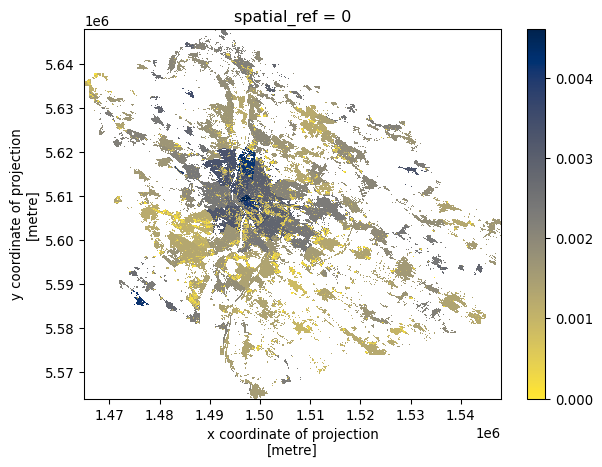

In [26]:
_ = pop_density.plot(cmap="cividis_r")

The resulting array can then be saved to a GeoTIFF using `rioxarray`.

In [27]:
pop_density.rio.to_raster("population_density.tif")

### Extracting values for locations with `xvec`

A common need is to extract values from raster data for a specific
location of interest. That is a first type of interaction between raster
and vector data (points in this case). To illustrate the use case,
create a set of random points covering the area of `budapest`.

In [28]:
locations = budapest.sample_points(1000).explode(ignore_index=True)
locations.head()


0    POINT (1469102.024 5634737.620)
1    POINT (1469641.529 5636938.256)
2    POINT (1469751.553 5635445.101)
3    POINT (1470021.852 5634674.177)
4    POINT (1470094.082 5625005.048)
Name: sampled_points, dtype: geometry

Check how the sample looks on a map.

In [29]:
locations.explore()

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<html>
<head>
 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-3.7.1.min.js"></script>
 <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://netdna.bootstrapcdn.com/bootstrap/3.0.0/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@fortawesome/fontawesome-free@6.2.0/css/all.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_e251b8f95f064bce8109239b78c043a3 {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 .leaflet-container { font-size: 1rem; }
 </style>
 
</head>
<body>
 
 
 <div class="folium-map" id="map_e251b8f95f064bce8109239b78c043a3" ></div>
 
</body>
<script>
 
 
 var map_e251b8f95f064bce8109239b78c043a3 = L.map(
 "map_e251b8f95f064bce8109239b78c043a3",
 {
 center: [47.464701360561705, 19.21364764830095],
 crs: L.CRS.EPSG3857,
 zoom: 10,
 zoomControl: true,
 preferCanvas: false,
 }
 );
 L.control.scale().addTo(map_e251b8f95f064bce8109239b78c043a3);

 

 
 
 var tile_layer_de8bc891b3f707bda5e0f716b3f14b34 = L.tileLayer(
 "https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png",
 {"attribution": "Data by \u0026copy; \u003ca target=\"_blank\" href=\"http://openstreetmap.org\"\u003eOpenStreetMap\u003c/a\u003e, under \u003ca target=\"_blank\" href=\"http://www.openstreetmap.org/copyright\"\u003eODbL\u003c/a\u003e.", "detectRetina": false, "maxNativeZoom": 18, "maxZoom": 18, "minZoom": 0, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 );
 
 
 tile_layer_de8bc891b3f707bda5e0f716b3f14b34.addTo(map_e251b8f95f064bce8109239b78c043a3);
 
 map_e251b8f95f064bce8109239b78c043a3.fitBounds(
 [[47.07800515759423, 18.729925170520218], [47.85139756352918, 19.69737012608168]],
 {}
 );
 
 
 function geo_json_7566bd8e118a113efb6417ffbc1c164f_styler(feature) {
 switch(feature.id) {
 default:
 return {"fillOpacity": 0.5, "weight": 2};
 }
 }
 function geo_json_7566bd8e118a113efb6417ffbc1c164f_highlighter(feature) {
 switch(feature.id) {
 default:
 return {"fillOpacity": 0.75};
 }
 }
 function geo_json_7566bd8e118a113efb6417ffbc1c164f_pointToLayer(feature, latlng) {
 var opts = {"bubblingMouseEvents": true, "color": "#3388ff", "dashArray": null, "dashOffset": null, "fill": true, "fillColor": "#3388ff", "fillOpacity": 0.2, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 2, "stroke": true, "weight": 3};
 
 let style = geo_json_7566bd8e118a113efb6417ffbc1c164f_styler(feature)
 Object.assign(opts, style)
 
 return new L.CircleMarker(latlng, opts)
 }

 function geo_json_7566bd8e118a113efb6417ffbc1c164f_onEachFeature(feature, layer) {
 layer.on({
 mouseout: function(e) {
 if(typeof e.target.setStyle === "function"){
 geo_json_7566bd8e118a113efb6417ffbc1c164f.resetStyle(e.target);
 }
 },
 mouseover: function(e) {
 if(typeof e

> **Random sampling and reproducibility**
>
> The points sampled from `budapest` will be different every time you
> run the `sample_points()` method. If you want to fix the result, you
> can pass a *seed* value to a random number generator as `rng=42`. With
> the same seed value, the result will be always the same. This is
> useful, especially if you are interested in the reproducibility of
> your code.

The `xarray` ecosystem offers many ways of extracting point values.
Below, you will use the implementation from the `xvec` package. Create a
new `xarray.DataArray` with all three arrays you created so far to see
the benefits of using `xvec` below.

In [30]:
bud_cube = xr.concat(
    [pop_density, population_bud, built_up_bud],
    dim=pd.Index(
        ["density", "population", "built-up volume"],
        name="measurement",
    )
)
bud_cube


<xarray.DataArray (measurement: 3, y: 840, x: 830)>
array([[[nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 ...,
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan]],

 [[nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 ...,
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan]],

 [[nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 ...,
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
 * x (x) float64 1.465e+06 1.465e+06 ... 1.548e+06 1.548e+06
 * y (y) float64 5.648e+06 5.648e+06 ... 5.564e+06 5.564e+06
 spatial_ref int64 0
 * measurement (measurement) object 'density' 'population' 'built-up volume' xarray.DataArray measurement : 3 y : 840 x : 830 nan nan nan nan nan nan nan nan ... nan nan nan nan nan nan nan nan array([[[nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 ...,
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan]],

 [[nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 ...,
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan]],

 [[nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 ...,
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan]]]) Coordinates: (4) x (x) float64 1.465e+06 1.465e+06 ... 1.548e+06 axis : X long_name : x coordinate of projection standard_name : projection_x_coordinate units : metre array([1465050., 1465150., 1465250., ..., 1547750., 1547850., 1547950.]) y (y) float64 5.648e+06 5.648e+06 ... 5.564e+06 axis : Y long_name : y coordinate of projection standard_name : projection_y_coordinate units : metre array([5647950., 5647850., 5647750., ..., 5564250., 5564150., 5564050.]) spatial_ref () int64 0 crs_wkt : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] spatial_ref : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] GeoTransform : 1465000.0 100.0 0.0 5648000.0 0.0 -100.0 array(0) measurement (measurement) object 'density' ... 'built-up volume' array(['density', 'population', 'built-up volume'], dtype=object) Indexes: (3) x PandasIndex PandasIndex(Index([1465050.0, 1465150.0, 1465250.0, 1465350.0, 1465450.0, 1465550.0,
 1465650.0, 1465750.0, 1465850.0, 1465950.0,
 ...
 1547050.0, 1547150.0, 1547250.0, 1547350.0, 1547450.0, 1547550.0,
 1547650.0, 1547750.0, 1547850.0, 1547950.0],
 dtype='float64', name='x', length=830)) y PandasIndex PandasIndex(Index([5647950.0, 5647850.0, 5647750.0, 5647650.0, 5647550.0, 5647450.0,
 5647350.0, 5647250.0, 5647150.0, 5647050.0,
 ...
 5564950.0, 5564850.0, 5564750.0, 5564650.0, 5564550.0, 5564450.0,
 5564350.0, 5564250.0, 5564150.0, 5564050.0],
 dtype='float64', name='y', length=840)) measurement PandasIndex

The resulting `DataArray` is 3-dimensional, compared to 2-dimensional
arrays used before. Apart from `x` and `y`, you now have `measurement`
as well. Using the new index created above, you can use the `sel()`
method to get the original arrays.

In [31]:
bud_cube.sel(measurement="density")

<xarray.DataArray (y: 840, x: 830)>
array([[nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 ...,
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
 * x (x) float64 1.465e+06 1.465e+06 ... 1.548e+06 1.548e+06
 * y (y) float64 5.648e+06 5.648e+06 ... 5.564e+06 5.564e+06
 spatial_ref int64 0
 measurement <U7 'density' xarray.DataArray y : 840 x : 830 nan nan nan nan nan nan nan nan ... nan nan nan nan nan nan nan nan array([[nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 ...,
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan]]) Coordinates: (4) x (x) float64 1.465e+06 1.465e+06 ... 1.548e+06 axis : X long_name : x coordinate of projection standard_name : projection_x_coordinate units : metre array([1465050., 1465150., 1465250., ..., 1547750., 1547850., 1547950.]) y (y) float64 5.648e+06 5.648e+06 ... 5.564e+06 axis : Y long_name : y coordinate of projection standard_name : projection_y_coordinate units : metre array([5647950., 5647850., 5647750., ..., 5564250., 5564150., 5564050.]) spatial_ref () int64 0 crs_wkt : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] spatial_ref : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] GeoTransform : 1465000.0 100.0 0.0 5648000.0 0.0 -100.0 array(0) measurement () <U7 'density' array('density', dtype='<U7') Indexes: (2) x PandasIndex PandasIndex(Index([1465050.0, 1465150.0, 1465250.0, 1465350.0, 1465450.0, 1465550.0,
 1465650.0, 1465750.0, 1465850.0, 1465950.0,
 ...
 1547050.0, 1547150.0, 1547250.0, 1547350.0, 1547450.0, 1547550.0,
 1547650.0, 1547750.0, 1547850.0, 1547950.0],
 dtype='float64', name='x', length=830)) y PandasIndex PandasIndex(Index([5647950.0, 5647850.0, 5647750.0, 5647650.0, 5647550.0, 5647450.0,
 5647350.0, 5647250.0, 5647150.0, 5647050.0,
 ...
 5564950.0, 5564850.0, 5564750.0, 5564650.0, 5564550.0, 5564450.0,
 5564350.0, 5564250.0, 5564150.0, 5564050.0],
 dtype='float64', name='y', length=840)) Attributes: (0)

Now it is time to take this *cube* and create another based on your
points. That can be done using the `.xvec` accessor and its
`extract_points` method.

In [32]:
vector_cube = bud_cube.drop_vars("spatial_ref").xvec.extract_points(
    points=locations.geometry,
    x_coords="x",
    y_coords="y",
)
vector_cube


<xarray.DataArray (measurement: 3, geometry: 1000)>
array([[nan, nan, nan, ..., nan, nan, nan],
 [ 0., 0., 0., ..., 0., 0., 0.],
 [ 0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
 * measurement (measurement) object 'density' 'population' 'built-up volume'
 * geometry (geometry) object POINT (1469102.023650728 5634737.61985494)...
Indexes:
 geometry GeometryIndex (crs=ESRI:54009) xarray.DataArray measurement : 3 geometry : 1000 nan nan nan nan nan nan nan nan ... 0.0 20.0 835.0 0.0 0.0 0.0 0.0 0.0 array([[nan, nan, nan, ..., nan, nan, nan],
 [ 0., 0., 0., ..., 0., 0., 0.],
 [ 0., 0., 0., ..., 0., 0., 0.]]) Coordinates: (2) measurement (measurement) object 'density' ... 'built-up volume' array(['density', 'population', 'built-up volume'], dtype=object) geometry (geometry) object POINT (1469102.023650728 5634737... crs : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","54009"]] array([<POINT (1469102.024 5634737.62)>, <POINT (1469641.529 5636938.256)>,
 <POINT (1469751.553 5635445.101)>, ...,
 <POINT (1545916.835 5598166.197)>, <POINT (1547296.855 5601697.236)>,
 <POINT (1547487.114 5600050.269)>], dtype=object) Indexes: (2) measurement PandasIndex PandasIndex(Index(['density', 'population', 'built-up volume'], dtype='object', name='measurement')) geometry GeometryIndex (crs=ESRI:54009) <xvec.index.GeometryIndex object at 0x7f0d14db4150> Attributes: (0)

The resulting object is still a `DataArray` but a bit different. It is
no longer 3-dimensional, although all dimensions of interest
(`'density', 'population', 'built-up volume'`) are still there, but
2-dimensional. One dimension is `measurement`, and the other is
`geometry`, containing the points of interest. With `xvec`, the spatial
dimension is reduced, but the remaining dimensionality of the original
array is preserved.

You can then convert the data into a `geopandas.GeoDataFrame` and work
with it as usual.

In [33]:
location_data = vector_cube.xvec.to_geopandas()
location_data.head()

Check the result on a map to verify that all worked as expected.

In [34]:
location_data.explore("density", cmap="cividis_r", tiles="CartoDB Positron")

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<html>
<head>
 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-3.7.1.min.js"></script>
 <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://netdna.bootstrapcdn.com/bootstrap/3.0.0/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@fortawesome/fontawesome-free@6.2.0/css/all.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_417999898c40ef3658777b7c4b1673c7 {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 .leaflet-container { font-size: 1rem; }
 </style>
 
 
 <style>
 .foliumtooltip {
 
 }
 .foliumtooltip table{
 margin: auto;
 }
 .foliumtooltip tr{
 text-align: left;
 }
 .foliumtooltip th{
 padding: 2px; padding-right: 8px;
 }
 </style>
 
 <script src="https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.5/d3.min.js"></script>
</head>
<body>
 
 
 <div class="folium-map" id="map_417999898c40ef3658777b7c4b1673c7" ></div>
 
</body>
<script>
 
 
 var map_417999898c40ef3658777b7c4b1673c7 = L.map(
 "map_417999898c40ef3658777b7c4b1673c7",
 {
 center: [47.464701360561705, 19.21364764830095],
 crs: L.CRS.EPSG3857,
 zoom: 10,
 zoomControl: true,
 preferCanvas: false,
 }
 );
 L.control.scale().addTo(map_417999898c40ef3658777b7c4b1673c7);

 

 
 
 var tile_layer_627ae9ec9d1f67157e62bb34df8de7bb = L.tileLayer(
 "https://a.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png",
 {"attribution": "\u0026copy; \u003ca href=\"https://www.openstreetmap.org/copyright\"\u003eOpenStreetMap\u003c/a\u003e contributors \u0026copy; \u003ca href=\"https://carto.com/attributions\"\u003eCARTO\u003c/a\u003e", "detectRetina": false, "maxNativeZoom": 20, "maxZoom": 20, "minZoom": 0, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 );
 
 
 tile_layer_627ae9ec9d1f67157e62bb34df8de7bb.addTo(map_417999898c40ef3658777b7c4b1673c7);
 
 map_417999898c40ef3658777b7c4b1673c7.fitBounds(
 [[47.07800515759423, 18.729925170520218], [47.85139756352918, 19.69737012608168]],
 {}
 );
 
 
 function geo_json_7321b2b7fe98c82148b7315bb8fafc62_styler(feature) {
 switch(feature.id) {
 case "0": case "1": case "2": case "3": case "4": case "5": case "6": case "7": case "8": case "11": case "12": case "13": case "14": case "15": case "17": case "18": case "19": case "20": case "21": case "22": case "23": case "24": case "25": case "26": case "27": case "28": case "29": case "30": case "31": case "32": case "33": case "34": case "36": case "37": case "38": case "39": case "40": case "41": case "42": case "43": case "45": case "46": case "47": case "48": case "49": case "51": case "52": case "54": case "55": case "57": case "59": case "60": case "61": case "62": case "63": case "64": case "65": case "66": case "67": case "69": case "70": case "71": case "74": case "75": case "76": case "77": case "78": case

> **Vector data cubes**
>
> The data structure `vector_cube` represents is called a vector data
> cube. It is a special case of an `xarray` N-dimensional object, where
> at least one dimension is indexed by geometries. See more in the [Xvec
> documentation](https://xvec.readthedocs.io/en/stable/intro.html).

## Zonal statistics with `geocube`

Another operation when working with rasters is the transfer of values
from an array to a set of polygons. This is called *zonal statistics*
and can be done in many ways, depending on the use case. When your
polygons are large compared to cells of the array, a good option is to
use a `geocube` package.

### Downloading OpenStreetMap data

You may be interested in the average population density in individual
districts of Budapest. One option for getting the geometries
representing the districts is the
[OpenStreetMap](https://www.openstreetmap.org/). Everything you can see
on OpenStreetMap is downloadable. In Python, a recommended way (when not
doing large downloads) is the `osmnx` package (imported as `ox`). The
detailed explanation of `osmnx` is out of scope for this session, but if
you are interested in details, check the official [Getting
started](https://osmnx.readthedocs.io/en/stable/getting-started.html)
guide.

In [35]:
admin_level_9 = ox.features_from_place("Budapest", {"admin_level": "9"})
districts = admin_level_9[admin_level_9.geom_type == "Polygon"][
    ["name", "name:en", "geometry"]
]
districts["key"] = range(len(districts))


### Plotting raster and vector together

Both `xarray` and `geopandas` can create `matplotlib` plots that can be
combined to see how the two overlap.

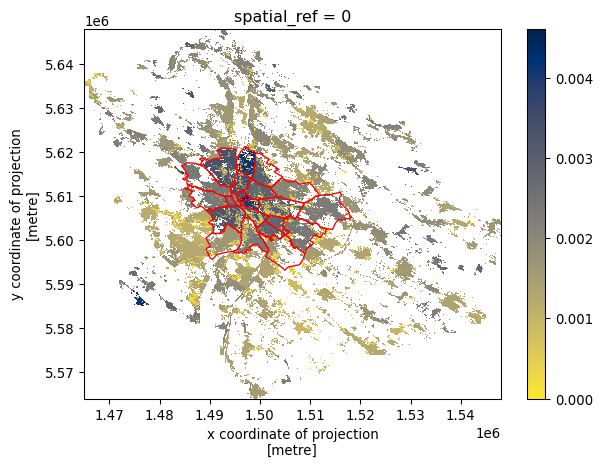

In [36]:
f, ax = plt.subplots()
pop_density.plot(ax=ax, cmap="cividis_r")
districts.to_crs(pop_density.rio.crs).plot(
    ax=ax, facecolor="none", edgecolor="red", linewidth=1, aspect=None
);


### Zonal statistics

Zonal statistics using `geocube` has three conceptual phases.

1.  Convert the geometry to an aligned raster, bringing the ID of each
    polygon to a raster format.
2.  Merge of the two arrays.
3.  Groupby operation using the IDs as grouping keys.

Let’s start with the first one.

In [37]:
districts_grid = make_geocube(
    vector_data=districts,
    measurements=["key"],
    like=pop_density,
)
districts_grid


<xarray.Dataset>
Dimensions: (y: 840, x: 830)
Coordinates:
 * y (y) float64 5.648e+06 5.648e+06 ... 5.564e+06 5.564e+06
 * x (x) float64 1.465e+06 1.465e+06 ... 1.548e+06 1.548e+06
 spatial_ref int64 0
Data variables:
 key (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan xarray.Dataset Dimensions: y : 840 x : 830 Coordinates: (3) y (y) float64 5.648e+06 5.648e+06 ... 5.564e+06 axis : Y long_name : y coordinate of projection standard_name : projection_y_coordinate units : metre array([5647950., 5647850., 5647750., ..., 5564250., 5564150., 5564050.]) x (x) float64 1.465e+06 1.465e+06 ... 1.548e+06 axis : X long_name : x coordinate of projection standard_name : projection_x_coordinate units : metre array([1465050., 1465150., 1465250., ..., 1547750., 1547850., 1547950.]) spatial_ref () int64 0 crs_wkt : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] spatial_ref : PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] GeoTransform : 1465000.0 100.0 0.0 5648000.0 0.0 -100.0 array(0) Data variables: (1) key (y, x) float64 nan nan nan nan ... nan nan nan nan name : key long_name : key _FillValue : nan array([[nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 ...,
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan],
 [nan, nan, nan, ..., nan, nan, nan]]) Indexes: (2) y PandasIndex PandasIndex(Index([5647950.0, 5647850.0, 5647750.0, 5647650.0, 5647550.0, 5647450.0,
 5647350.0, 5647250.0, 5647150.0, 5647050.0,
 ...
 5564950.0, 5564850.0, 5564750.0, 5564650.0, 5564550.0, 5564450.0,
 5564350.0, 5564250.0, 5564150.0, 5564050.0],
 dtype='float64', name='y', length=840)) x PandasIndex PandasIndex(Index([1465050.0, 1465150.0, 1465250.0, 1465350.0, 1465450.0, 1465550.0,
 1465650.0, 1465750.0, 1465850.0, 1465950.0,
 ...
 1547050.0, 1547150.0, 1547250.0, 1547350.0, 1547450.0, 1547550.0,
 1547650.0, 1547750.0, 1547850.0, 1547950.0],
 dtype='float64', name='x', length=830)) Attributes: (0)

You can visually check the resulting raster by plotting the `"key"`
variable.

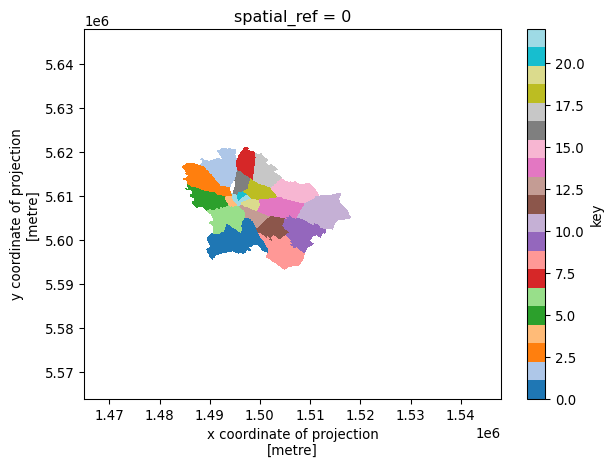

In [38]:
_ = districts_grid.key.plot.imshow(cmap="tab20")


The second and third steps outlined above can be combined into a single
one. You can directly group `pop_density` by the array stored in
`districts_grid.key`.

In [39]:
grouped_density = pop_density.groupby(districts_grid.key)
grouped_density

DataArrayGroupBy, grouped over 'key'
23 groups with labels 0.0, 1.0, 2.0, ..., 20.0, 21.0, 22.0.

This gives you a similar `GroupBy` object you know from `pandas`. You
can get any type of aggregation from the object and assign it directly
back to the `GeoDataFrame`.

In [40]:
districts["mean_density"] = grouped_density.mean()

Check the result!

In [41]:
districts.explore("mean_density", cmap="cividis_r", tiles="CartoDB Positron")

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<html>
<head>
 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-3.7.1.min.js"></script>
 <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://netdna.bootstrapcdn.com/bootstrap/3.0.0/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@fortawesome/fontawesome-free@6.2.0/css/all.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_bd0891fdbe564ab1323b9a88457ba73c {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 .leaflet-container { font-size: 1rem; }
 </style>
 
 
 <style>
 .foliumtooltip {
 
 }
 .foliumtooltip table{
 margin: auto;
 }
 .foliumtooltip tr{
 text-align: left;
 }
 .foliumtooltip th{
 padding: 2px; padding-right: 8px;
 }
 </style>
 
 <script src="https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.5/d3.min.js"></script>
</head>
<body>
 
 
 <div class="folium-map" id="map_bd0891fdbe564ab1323b9a88457ba73c" ></div>
 
</body>
<script>
 
 
 var map_bd0891fdbe564ab1323b9a88457ba73c = L.map(
 "map_bd0891fdbe564ab1323b9a88457ba73c",
 {
 center: [47.48141835, 19.13001575],
 crs: L.CRS.EPSG3857,
 zoom: 10,
 zoomControl: true,
 preferCanvas: false,
 }
 );
 L.control.scale().addTo(map_bd0891fdbe564ab1323b9a88457ba73c);

 

 
 
 var tile_layer_572d49d54cafd2af85e0e7eb7e924015 = L.tileLayer(
 "https://a.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png",
 {"attribution": "\u0026copy; \u003ca href=\"https://www.openstreetmap.org/copyright\"\u003eOpenStreetMap\u003c/a\u003e contributors \u0026copy; \u003ca href=\"https://carto.com/attributions\"\u003eCARTO\u003c/a\u003e", "detectRetina": false, "maxNativeZoom": 20, "maxZoom": 20, "minZoom": 0, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 );
 
 
 tile_layer_572d49d54cafd2af85e0e7eb7e924015.addTo(map_bd0891fdbe564ab1323b9a88457ba73c);
 
 map_bd0891fdbe564ab1323b9a88457ba73c.fitBounds(
 [[47.3496899, 18.9251057], [47.6131468, 19.3349258]],
 {}
 );
 
 
 function geo_json_4ee19a7aefe00a523f7c53bcd728ea98_styler(feature) {
 switch(feature.id) {
 case "(\u0027relation\u0027, 215618)": 
 return {"color": "#d1bf61", "fillColor": "#d1bf61", "fillOpacity": 0.5, "weight": 2};
 case "(\u0027relation\u0027, 215621)": 
 return {"color": "#f9e03a", "fillColor": "#f9e03a", "fillOpacity": 0.5, "weight": 2};
 case "(\u0027relation\u0027, 221976)": 
 return {"color": "#707173", "fillColor": "#707173", "fillOpacity": 0.5, "weight": 2};
 case "(\u0027relation\u0027, 221980)": 
 return {"color": "#ada272", "fillColor": "#ada272", "fillOpacity": 0.5, "weight": 2};
 case "(\u0027relation\u0027, 221984)": case "(\u0027relation\u0027, 1551290)": 
 return {"color": "#928d78", "fillColor": "#928d78", "fillOpacity": 0.5, "weight": 2};
 case "(\u0027relation\u0027, 221995)": 
 return {"color": "#b3a670", "fillColor": "#b3a670", "

> **Additional reading**
>
> Have a look at the chapter [*Local Spatial
> Autocorrelation*](https://geographicdata.science/book/notebooks/07_local_autocorrelation.html#bonus-local-statistics-on-surfaces)
> from the Geographic Data Science with Python by @rey2023geographic to
> learn how to do LISA on rasters.
>
> The great resource on xarray is their
> [tutorial](https://tutorial.xarray.dev/intro.html).